### Choosing the Right Metric


<center>
    <img src = 'images/uci_biz.png'/>
</center>


This module introduced both the K Nearest Neighbors model as well as a variety of different metrics for classification.  It is important to select and understand the appropriate metric for your task.  This exercise is meant to get practice considering the difference between these new classification metrics and accompanying evaluation tools. Specifically, explore datasets related to business from the UCI Machine Learning Repository [here](https://archive-beta.ics.uci.edu/ml/datasets?f%5Barea%5D%5B0%5D=business&p%5Boffset%5D=0&p%5Blimit%5D=10&p%5BorderBy%5D=NumHits&p%5Border%5D=desc&p%5BStatus%5D=APPROVED).  

Select a dataset of interest and clearly state the classification task.  Specifically, describe a business problem that could be solved using the dataset and a KNN classification model.  Further, identify what you believe to be the appropriate metric and justify your choice.  Build a basic model with the `KNearestNeighbor` and grid search to optimize towards your chosen metric.  Share your results with your peers.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
set_config("figure")


**Dataset and business question**

I selected the Dow Jones Index dataset from the UCI repository. It contains price and volume data for 30 stocks over two quarters, by week. It has 750 weeks and 14 features. The target feature is  the percent change in price for each stock in the following week. The business question is picking stocks that are likely to gain value.

Since the target feature is continous in this dataset, I created a new target variable with two classes. The "super" class will represent stocks whose percent change in price increased more than 3% in next week's price. All other stocks will be classified together, regardless of whether their price increased or decreased. This answers the business question by picking super stocks that had a significant percent increase in price from week to week.

In the dataset documentation the authors noted that they used Q1 as the training set and Q2 as the test set, so I replicated this method in my analysis.

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
dow_jones_index = fetch_ucirepo(id=312)

# data (as pandas dataframes)
X = dow_jones_index.data.features
y = dow_jones_index.data.targets

# metadata
print(dow_jones_index.metadata)

# variable information
print(dow_jones_index.variables)


{'uci_id': 312, 'name': 'Dow Jones Index', 'repository_url': 'https://archive.ics.uci.edu/dataset/312/dow+jones+index', 'data_url': 'https://archive.ics.uci.edu/static/public/312/data.csv', 'abstract': 'This dataset contains weekly data for the Dow Jones Industrial Index.  It has been used in computational investing research.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Time-Series'], 'num_instances': 750, 'num_features': 15, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['percent_change_next_weeks_price'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2013, 'last_updated': 'Sat Mar 09 2024', 'dataset_doi': '10.24432/C5788V', 'creators': ['Michael Brown'], 'intro_paper': {'title': 'Dynamic-Radius Species-Conserving Genetic Algorithm for the Financial Forecasting of Dow Jones Index Stocks', 'authors': 'M. S. Brown, M. Pelosi, Henry Dirska', 'published_in': 'IAPR

**Exploratory analysis and data cleaning with predictor features in X dataframe**

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   quarter                             750 non-null    int64  
 1   stock                               750 non-null    object 
 2   date                                750 non-null    object 
 3   open                                750 non-null    object 
 4   high                                750 non-null    object 
 5   low                                 750 non-null    object 
 6   close                               750 non-null    object 
 7   volume                              750 non-null    int64  
 8   percent_change_price                750 non-null    float64
 9   percent_change_volume_over_last_wk  720 non-null    float64
 10  previous_weeks_volume               720 non-null    float64
 11  next_weeks_open                     750 non-n

In [ ]:
X.tail()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,days_to_next_dividend,percent_return_next_dividend
745,2,XOM,5/27/2011,$80.22,$82.63,$80.07,$82.63,68230855,3.00424,-21.355713,86758820.0,$83.28,$81.18,75,0.568801
746,2,XOM,6/3/2011,$83.28,$83.75,$80.18,$81.18,78616295,-2.52161,15.221032,68230855.0,$80.93,$79.78,68,0.578960
747,2,XOM,6/10/2011,$80.93,$81.87,$79.72,$79.78,92380844,-1.42098,17.508519,78616295.0,$80.00,$79.02,61,0.589120
748,2,XOM,6/17/2011,$80.00,$80.82,$78.33,$79.02,100521400,-1.22500,8.811952,92380844.0,$78.65,$76.78,54,0.594786
749,2,XOM,6/24/2011,$78.65,$81.12,$76.78,$76.78,118679791,-2.37762,18.064204,100521400.0,$76.88,$82.01,47,0.612139


In [ ]:
X.describe()

,quarter,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,days_to_next_dividend,percent_return_next_dividend
count,750.000000,7.500000e+02,750.000000,720.000000,7.200000e+02,750.000000,750.000000
mean,1.520000,1.175478e+08,0.050262,5.593627,1.173876e+08,52.525333,0.691826
std,0.499933,1.584381e+08,2.517809,40.543478,1.592322e+08,46.335098,0.305482
min,1.000000,9.718851e+06,-15.422900,-61.433175,9.718851e+06,0.000000,0.065574
25%,1.000000,3.086624e+07,-1.288053,-19.804284,3.067832e+07,24.000000,0.534549
50%,2.000000,5.306088e+07,0.000000,0.512586,5.294556e+07,47.000000,0.681067
75%,2.000000,1.327218e+08,1.650888,21.800622,1.333230e+08,69.000000,0.854291
max,2.000000,1.453439e+09,9.882230,327.408924,1.453439e+09,336.000000,1.564210


In [ ]:
object_cols = X.select_dtypes('object').columns.tolist()
print(object_cols)

['stock', 'date', 'open', 'high', 'low', 'close', 'next_weeks_open', 'next_weeks_close']


In [ ]:
#Convert numbers stored as objects to numeric
X['open'] = X['open'].str.replace('$', '')
X['open'] = X['open'].astype(float)
X['high'] = X['high'].str.replace('$', '')
X['high'] = X['high'].astype(float)
X['low'] = X['low'].str.replace('$', '')
X['low'] = X['low'].astype(float)
X['close'] = X['close'].str.replace('$', '')
X['close'] = X['close'].astype(float)
X['next_weeks_open'] = X['next_weeks_open'].str.replace('$', '')
X['next_weeks_open'] = X['next_weeks_open'].astype(float)
X['next_weeks_close'] = X['next_weeks_close'].str.replace('$', '')
X['next_weeks_close'] = X['next_weeks_close'].astype(float)
X.describe()


,quarter,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,days_to_next_dividend,percent_return_next_dividend
count,750.000000,750.000000,750.000000,750.000000,750.000000,7.500000e+02,750.000000,720.000000,7.200000e+02,750.000000,750.000000,750.000000,750.000000
mean,1.520000,53.651840,54.669987,52.640160,53.729267,1.175478e+08,0.050262,5.593627,1.173876e+08,53.702440,53.889080,52.525333,0.691826
std,0.499933,32.638852,33.215994,32.119277,32.788787,1.584381e+08,2.517809,40.543478,1.592322e+08,32.778111,33.016677,46.335098,0.305482
min,1.000000,10.590000,10.940000,10.400000,10.520000,9.718851e+06,-15.422900,-61.433175,9.718851e+06,10.520000,10.520000,0.000000,0.065574
25%,1.000000,29.830000,30.627500,28.720000,30.365000,3.086624e+07,-1.288053,-19.804284,3.067832e+07,30.315000,30.462500,24.000000,0.534549
50%,2.000000,45.970000,46.885000,44.800000,45.930000,5.306088e+07,0.000000,0.512586,5.294556e+07,46.015000,46.125000,47.000000,0.681067
75%,2.000000,72.715000,74.287500,71.037500,72.667500,1.327218e+08,1.650888,21.800622,1.333230e+08,72.715000,72.915000,69.000000,0.854291
max,2.000000,172.110000,173.540000,167.820000,170.580000,1.453439e+09,9.882230,327.408924,1.453439e+09,172.110000,174.540000,336.000000,1.564210


In [ ]:
print(X['quarter'].value_counts())
print(X['stock'].value_counts())
print(X['date'].value_counts())

quarter
2    390
1    360
Name: count, dtype: int64
stock
AA      25
AXP     25
WMT     25
VZ      25
UTX     25
TRV     25
T       25
PG      25
PFE     25
MSFT    25
MRK     25
MMM     25
MCD     25
KO      25
KRFT    25
JPM     25
JNJ     25
INTC    25
IBM     25
HPQ     25
HD      25
GE      25
DIS     25
DD      25
CVX     25
CSCO    25
CAT     25
BAC     25
BA      25
XOM     25
Name: count, dtype: int64
date
1/7/2011     30
4/8/2011     30
6/17/2011    30
6/10/2011    30
6/3/2011     30
5/27/2011    30
5/20/2011    30
5/13/2011    30
5/6/2011     30
4/29/2011    30
4/21/2011    30
4/15/2011    30
4/1/2011     30
1/14/2011    30
3/25/2011    30
3/18/2011    30
3/11/2011    30
3/4/2011     30
2/25/2011    30
2/18/2011    30
2/11/2011    30
2/4/2011     30
1/28/2011    30
1/21/2011    30
6/24/2011    30
Name: count, dtype: int64


In [ ]:
#Drop non-numeric features
X.drop(columns =['stock', 'date'], inplace = True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   quarter                             750 non-null    int64  
 1   open                                750 non-null    float64
 2   high                                750 non-null    float64
 3   low                                 750 non-null    float64
 4   close                               750 non-null    float64
 5   volume                              750 non-null    int64  
 6   percent_change_price                750 non-null    float64
 7   percent_change_volume_over_last_wk  720 non-null    float64
 8   previous_weeks_volume               720 non-null    float64
 9   next_weeks_open                     750 non-null    float64
 10  next_weeks_close                    750 non-null    float64
 11  days_to_next_dividend               750 non-n

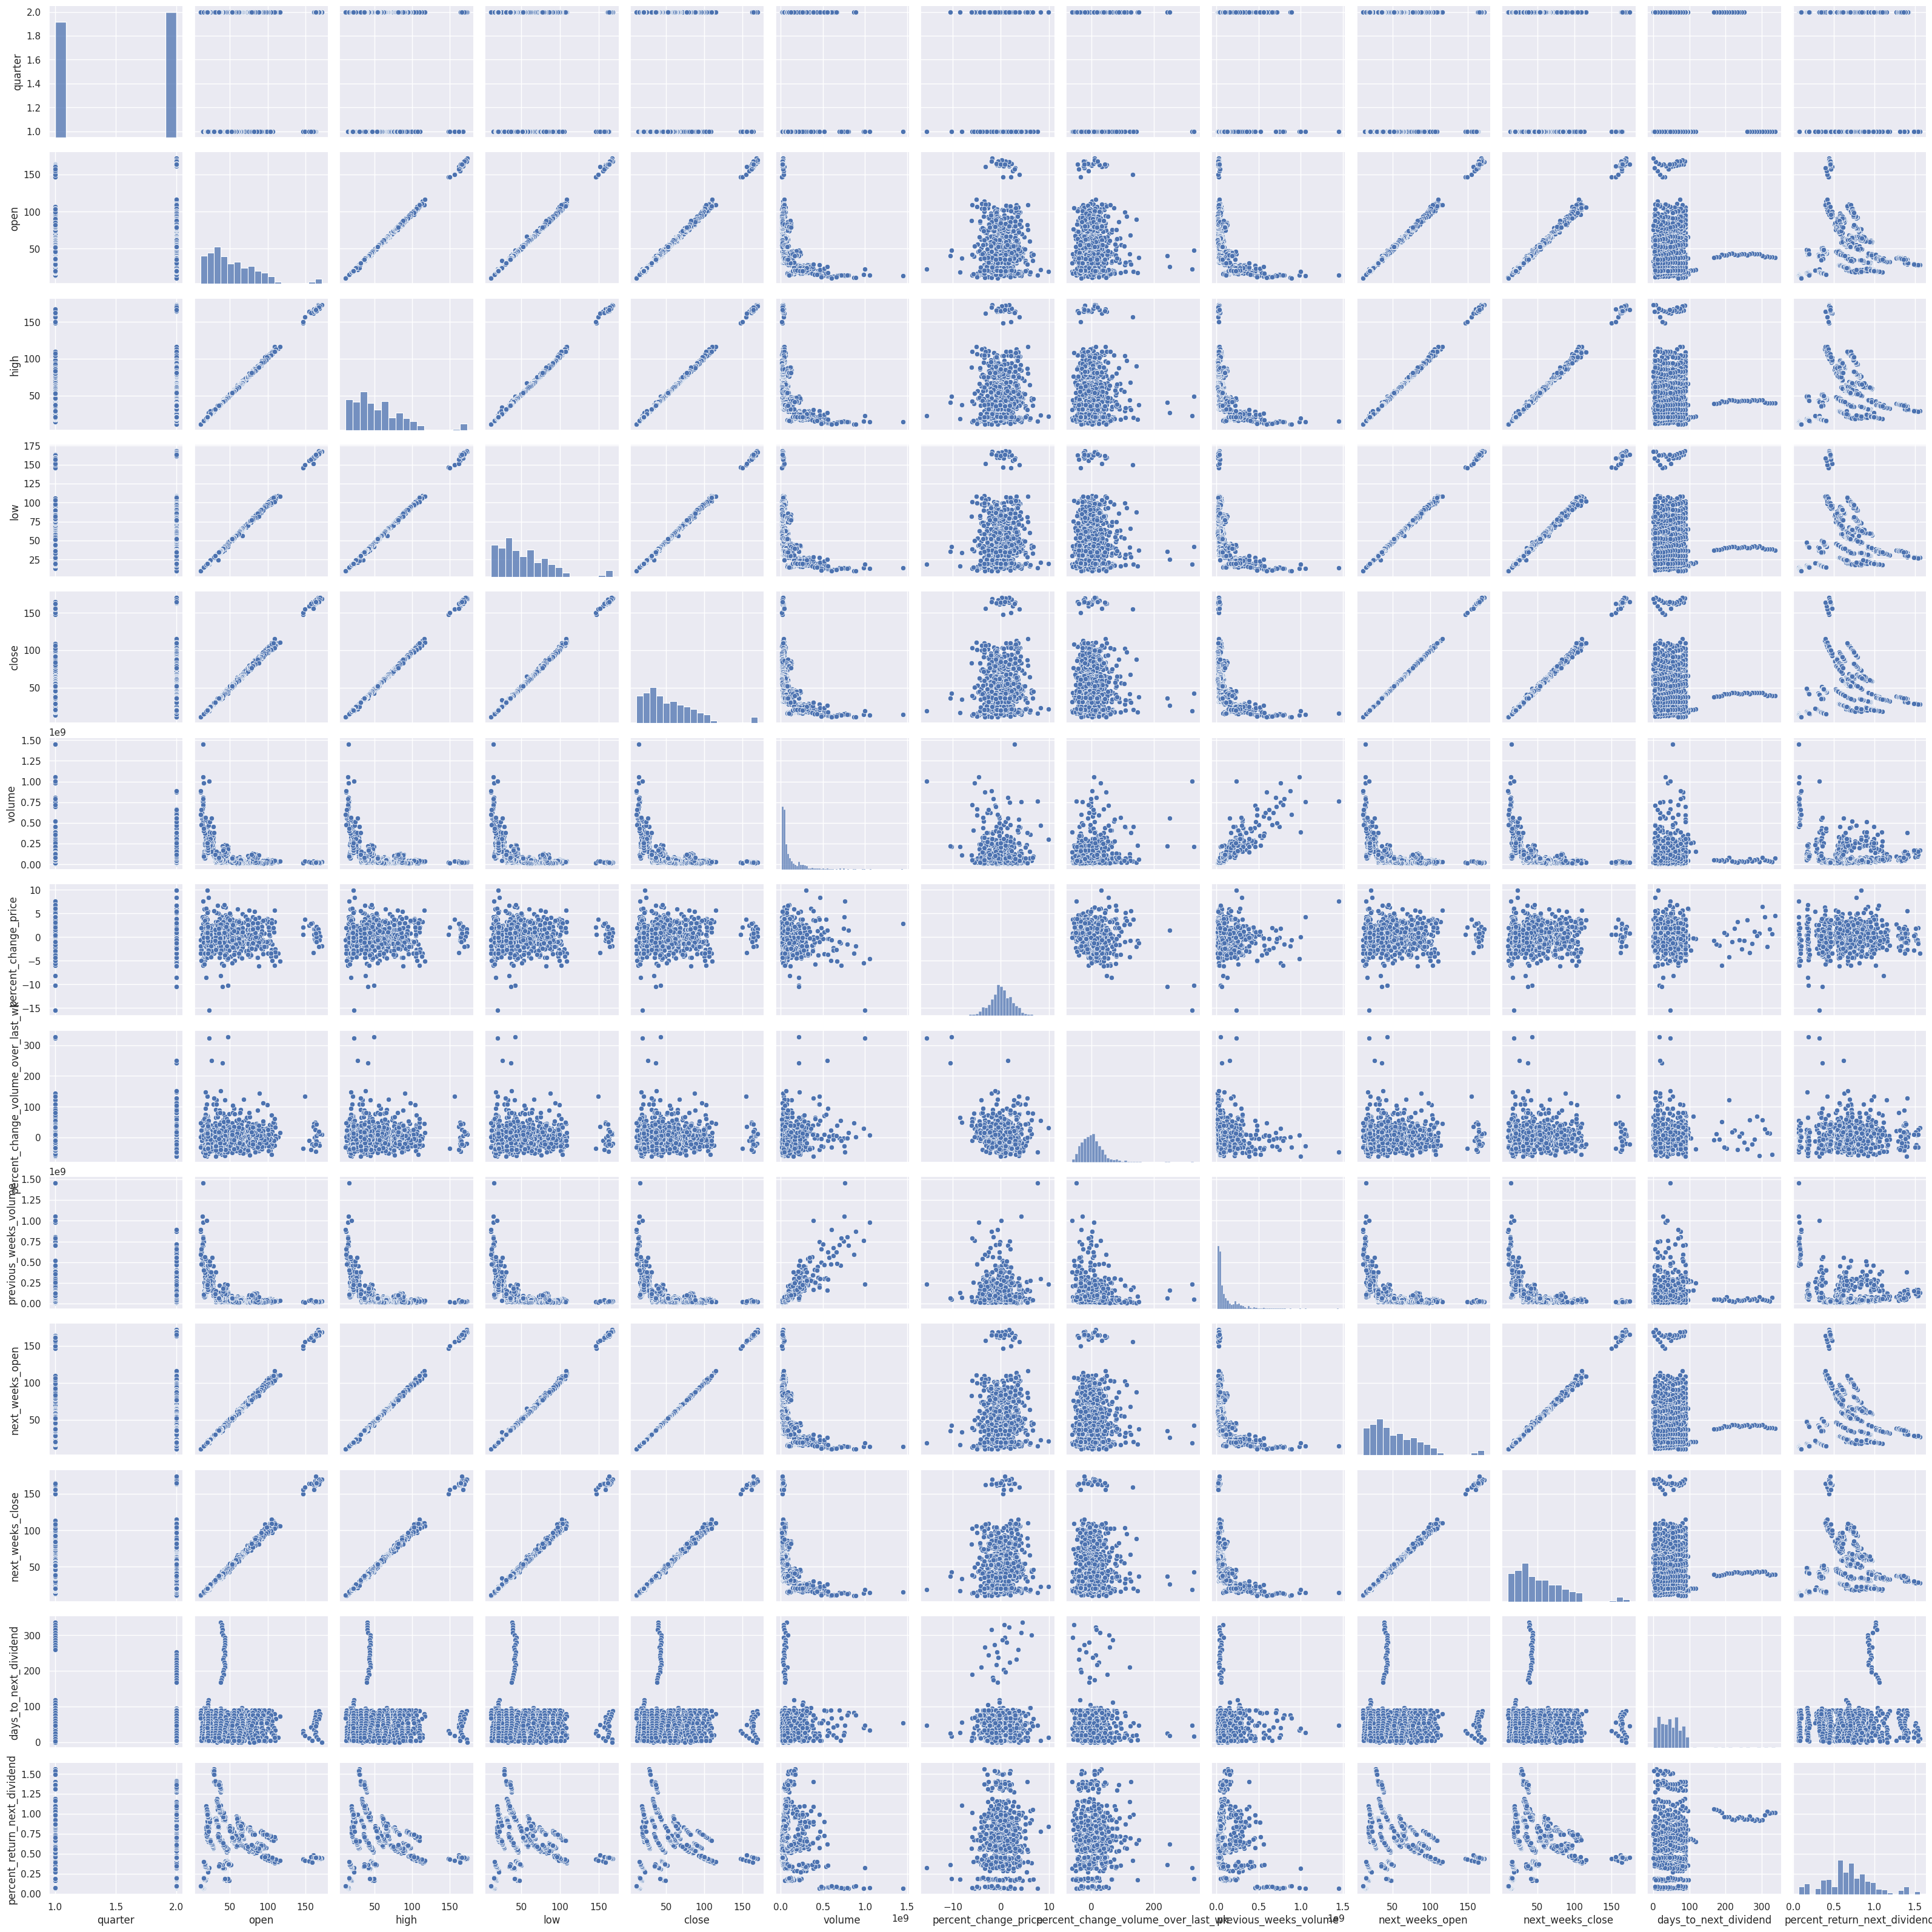

In [ ]:
#Look at correlations and scatters
p=sns.pairplot(numeric)

In [ ]:
#Drop features which are very highly correlated
X.drop(columns =['high', 'low', 'close', 'next_weeks_open', 'next_weeks_close', 'previous_weeks_volume'], inplace = True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   quarter                             750 non-null    int64  
 1   open                                750 non-null    float64
 2   volume                              750 non-null    int64  
 3   percent_change_price                750 non-null    float64
 4   percent_change_volume_over_last_wk  720 non-null    float64
 5   days_to_next_dividend               750 non-null    int64  
 6   percent_return_next_dividend        750 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 41.1 KB


In [ ]:
#Identify missing data
X.isnull().sum()

quarter                                0
open                                   0
volume                                 0
percent_change_price                   0
percent_change_volume_over_last_wk    30
days_to_next_dividend                  0
percent_return_next_dividend           0
dtype: int64

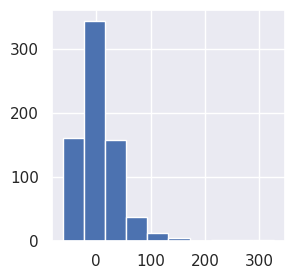

In [ ]:
#Look at distribution to select imputation method
p = X['percent_change_volume_over_last_wk'].hist(figsize = (3,3))

In [ ]:
#Impuation by mean for normally distributed features and by median for skewed distribution
X['percent_change_volume_over_last_wk'].fillna(X['percent_change_volume_over_last_wk'].mean(), inplace = True)
X.isnull().sum()

quarter                               0
open                                  0
volume                                0
percent_change_price                  0
percent_change_volume_over_last_wk    0
days_to_next_dividend                 0
percent_return_next_dividend          0
dtype: int64

**Exploratory analysis of Y target feature dataframe**

I created a new binary target feature for stocks whose price increased more than 3% from week to week. About 14% of the stock week records were classified as "super". The classification score of interest is Precision because we want to target investments to super stocks and lower the risk of losing money by investing in false positives.

In [ ]:
#Explore target feature
y.head()

,percent_change_next_weeks_price
0,-4.428490
1,-2.470660
2,1.638310
3,5.933250
4,0.230814


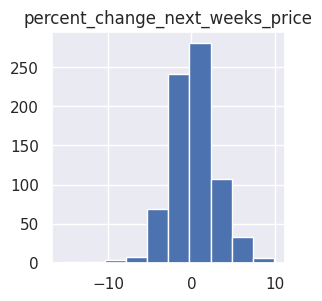

In [ ]:
p = y.hist(figsize = (3,3))

In [ ]:
y.describe()


,percent_change_next_weeks_price
count,750.000000
mean,0.238468
std,2.679538
min,-15.422900
25%,-1.222068
50%,0.101193
75%,1.845562
max,9.882230


In [ ]:
#Create a new target variable "super" for stocks whose price increased more than 3%
super=y>3
super = super.astype(int)
super.shape
super.describe()


,percent_change_next_weeks_price
count,750.000000
mean,0.140000
std,0.347219
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


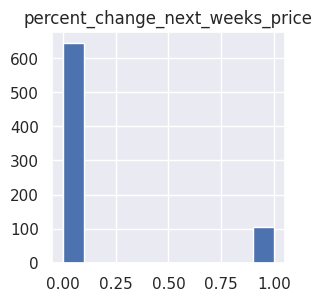

In [ ]:
#It appears about 14% of the stocks are "super"
p = super.hist(figsize = (3,3))

**Prepare for modeling**

I split the the data into train and test sets, then use a column transformer to normalize the numeric features using StandardScaler. Then I built a pipeline with steps for the transformer and for K Neighbors classifier.

In [ ]:
#Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, super, test_size=0.3, random_state = 42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(525, 7)
(525, 1)
(225, 7)
(225, 1)


In [ ]:
#Build a pipeline with scaling and KNN steps
knn_pipe = Pipeline([('transform', StandardScaler()), ('knn', KNeighborsClassifier())])
knn_pipe.fit(X_train, y_train)
preds = knn_pipe.predict(X_test)
test_mse = mean_squared_error(y_test, preds)

# Answer check
print('Test MSE:', test_mse)
knn_pipe


Test MSE: 0.1688888888888889


Pipeline(steps=[('transform', StandardScaler()),
                ('knn', KNeighborsClassifier())])

In [ ]:
#Grid search for optimal k, optimizing for precision
params = {'knn__n_neighbors': range(1, 20, 2)}
knn_grid = GridSearchCV(knn_pipe, param_grid=params, scoring='precision')
knn_grid.fit(X_train, y_train)
best_model = knn_grid.best_estimator_
best_params = knn_grid.best_params_
best_params


{'knn__n_neighbors': 3}

In [ ]:
#Check accuracy, precision and recall scores
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, best_model.predict(X_test))
recall = recall_score(y_test, best_model.predict(X_test))

print("Accuracy Score:", accuracy)
print('Precision: ', precision)
print('Recall: ', recall)

Accuracy Score: 0.7911111111111111
Precision:  0.18181818181818182
Recall:  0.12121212121212122


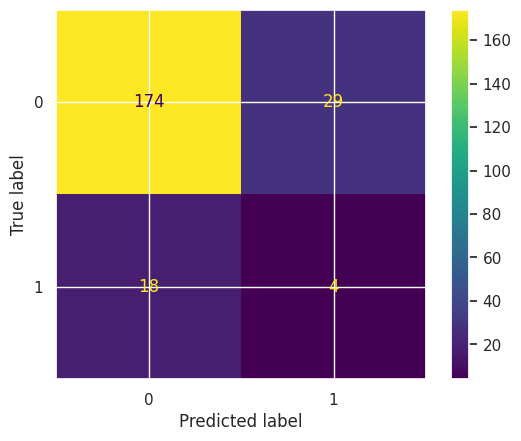

In [ ]:
#Display the confusion matrix
preds = knn_grid.predict(X_test)
confusion_mat = ConfusionMatrixDisplay.from_predictions(preds, y_test)

In [ ]:
#Summarize results in classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       192
           1       0.18      0.12      0.15        33

    accuracy                           0.79       225
   macro avg       0.52      0.51      0.51       225
weighted avg       0.76      0.79      0.77       225



In the end this is not a high accuracy classification model, as indicated by the accuracy score of .79. The precision score of .18 is higher than the recall score of .12, as we wanted. But this is a very low precision for targeting investments. We would need to add more information, like more features about the stocks, or a more weeks of price changes, to improve the precision.